# Multi-modal RAG with LangChain

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [6]:
from unstructured.partition.pdf import partition_pdf

In [7]:
file_path = '/home/elbahnasy/CodingWorkspace/Hands-On-LLMS/src/multimodality/attentionis all youneeed.pdf'
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    languages=["ar", "en"]
    )

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [8]:
set([str(type(chunk)) for chunk in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>",
 "<class 'unstructured.documents.elements.TableChunk'>"}

In [9]:
chunks[26].metadata.orig_elements

In [10]:
elements = chunks[26].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '84d1b9da-f0aa-4f77-9d40-af9c2991300c',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-04-20T23:44:37',
  'filetype': 'PPM',
  'languages': ['ar', 'en'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJi

### Separate extracted elements into tables, text, and images


In [11]:
# Helper functions for type checks
def is_table(chunk):
    return "Table" in str(type(chunk))

def is_composite(chunk):
    return "CompositeElement" in str(type(chunk))

# Separate tables and texts using list comprehensions
tables = [chunk for chunk in chunks if is_table(chunk)]
texts = [chunk for chunk in chunks if is_composite(chunk)]

# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if is_composite(chunk):
            chunk_els = getattr(chunk.metadata, "orig_elements", [])
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(getattr(el.metadata, "image_base64", None))
    # Filter out any None values in case image_base64 is missing
    return [img for img in images_b64 if img]

images = get_images_base64(chunks)

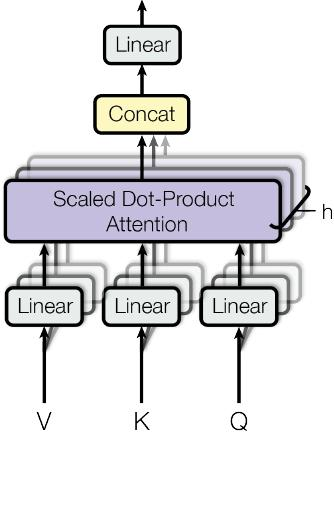

In [12]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[2])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

In [13]:
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [ ]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

model = ChatOpenAI(
    base_url="http://127.0.0.1:11434/v1/",
    api_key="ollama",  
    model="llama3.2:latest", 
    temperature=0.5
)

summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [15]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [19]:
text_summaries

['Table: 2023 paper publication data. Authors include Ashish Vaswani, Noam Shazeer, Niki Parmar, and Jakob Uszkoreit from Google Brain and Google Research.',
 'Researchers at Google Research: Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin.',
 'The Transformer model proposes a new sequence transduction architecture that uses only attention mechanisms, outperforming traditional recurrent and convolutional neural networks in machine translation tasks.',
 'Our model achieves significant improvements in translation accuracy, surpassing existing results by over 2 BLEU and setting a new single-model state-of-the-art score for English-to-French translation.',
 'Transformer generalized well to English constituency parsing, performing well with both large and limited training data.',
 'Key contributors to Transformer development include Jakob proposing self-attention, Ashish/Illia designing first models, Noam introducing scaled dot-product attention, and Niki evaluating and tun

In [17]:
table_summaries

["Model | EN-DE | BLEU EN-FR | Training EN-DE | Cost (FLOPs) EN-FR\nByteNet [18] | 23.75 | - | - | -\nDeep-Att + PosUnk | - | 39.2 | - | 1.0 - 107°\nGNMT + RL | 24.6 | 39.92 | 2.3-10!9 | 1.4-1070\nConvS28 [9] | 25.16 | 40.46 | 9.6-10% | 1.5-1070\nMoE | 26.03 | 40.56 | 2.0-10'9 | 1.2 - 107°\nDeep-Att + PosUnk Ensemble | - | 40.4 | - | 8.0 - 107°\nGNMT + RL Ensemble (33) | 26.30 | 41.16 | 1.8-1079 | 1.1 - 1074\nConvS2S Ensemble [9] | 26.36 | 41.29 | 7.7-10'9 | —1.2-107!\nTransformer (base model) | 27.3 | 38.1 | 3.3- | 1018\nTransformer (big) | 28.4 | 41.8 | - | 2.31019",
 'The table shows the results of different neural network architectures on a dataset, comparing their performance with varying input sizes and number of layers. The models are compared across various configurations, including positional embedding, sinusoids, and others.',
 'The table lists various sizes (big, 6, 1024, 4096, 16) with corresponding values (0.3, 300K, 4.33, 26.4, 213), likely representing measurements or da

### Image summaries

We will use qwen2.5vl to produce the image summaries.

In [ ]:
prompt_template = """Describe the image in detail. For context,
                    the image is part of a research paper explaining the transformers
                    architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

model = ChatOpenAI(
    base_url="http://127.0.0.1:11434/v1/",
    api_key="ollama",  
    model="qwen2.5vl", 
    temperature=0.5
)

chain = prompt | model | StrOutputParser()


image_summaries = chain.batch(images)

In [ ]:
display_base64_image(images[0])
print(image_summaries[0])

## Load data and summaries to vectorstore

### Create the vectorstore

In [ ]:
import uuid
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_ollama import OllamaEmbeddings 
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OllamaEmbeddings(model="nomic-embed-text"))

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)